In [1]:
import pandas as pd
import numpy as np
from os import getcwd, chdir, mkdir
import os
#print(getcwd())
os.chdir(r"C:\Users\user\Documents\projet_data")

In [2]:
bc = pd.read_csv('base_control_agreg.csv', sep=",", encoding = "ISO-8859-1", engine='python', index_col = 0)

In [3]:
# import matplotlib et seaborn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set() # pour modifier le thème

In [4]:
bc['Date'] = pd.to_datetime(bc['Date'], errors = 'coerce')

In [5]:
# On duplique l'heure et le mois pour les mettre transposer sur une horloge
import math
bc['h_x'] = bc.Heure_Origine
bc['h_y'] = bc.Heure_Origine

bc['m_x'] = bc.Month
bc['m_y'] = bc.Month

# On remplace les heure et le mois par les angles correspondants de l'horloge

bc['h_x'] = bc['h_x'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                             [5*math.pi/12, math.pi/3, math.pi/4, math.pi/6, math.pi/12, 0, -math.pi/12, -math.pi/6,
                             -math.pi/4, -math.pi/3, -5*math.pi/12, -math.pi/2, -7*math.pi/12, -2*math.pi/3, -3*math.pi/4,
                             -5*math.pi/6, -11*math.pi/12, math.pi, 11*math.pi/12, 5*math.pi/6, 3*math.pi/4, 2*math.pi/3,
                             7*math.pi/12])

bc['h_y'] = bc['h_y'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                             [5*math.pi/12, math.pi/3, math.pi/4, math.pi/6, math.pi/12, 0, -math.pi/12, -math.pi/6,
                             -math.pi/4, -math.pi/3, -5*math.pi/12, -math.pi/2, -7*math.pi/12, -2*math.pi/3, -3*math.pi/4,
                             -5*math.pi/6, -11*math.pi/12, math.pi, 11*math.pi/12, 5*math.pi/6, 3*math.pi/4, 2*math.pi/3,
                             7*math.pi/12])

bc['m_x'] = bc['m_x'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                             [math.pi/3, math.pi/6, 0, -math.pi/6, -math.pi/3, -math.pi/2, -2*math.pi/3, -5*math.pi/6, math.pi, 
                              5*math.pi/6, 2*math.pi/3, math.pi/2])

bc['m_y'] = bc['m_y'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                             [math.pi/3, math.pi/6, 0, -math.pi/6, -math.pi/3, -math.pi/2, -2*math.pi/3, -5*math.pi/6, math.pi, 
                              5*math.pi/6, 2*math.pi/3, math.pi/2])

# On applique cos et sin pour enregistrer les coordonnées de l'horloge

bc['h_x'] = bc['h_x'].apply(lambda x : math.cos(x))
bc['h_y'] = bc['h_y'].apply(lambda x : math.sin(x))

bc['m_x'] = bc['m_x'].apply(lambda x : math.cos(x))
bc['m_y'] = bc['m_y'].apply(lambda x : math.sin(x))

In [6]:
# On supprime l'année 2020 car la crise sanitaire sur cette année fait que la réalité des fraudes n'est pas représentée
bc_2019_cv = bc[bc['Year'] == 2019]

# On prends que les contrôleurs chevronnés car le modèle est meilleur avec que ceux là (ces contrôleurs sont meilleurs et 
# contrôlent en général tout le train)
bc_2019_cv = bc_2019_cv[bc_2019_cv['cv'] == 1]

In [7]:
bc_2019_cv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14271 entries, 37 to 100347
Data columns (total 26 columns):
Date                          14271 non-null datetime64[ns]
Num_Train                     14271 non-null int64
Year                          14271 non-null int64
Month                         14271 non-null int64
15zaine_jour                  14271 non-null object
Sous_Ligne                    14271 non-null object
Direction_Ligne               14271 non-null object
Gare_Origine                  14271 non-null object
Heure_Origine                 14271 non-null int64
Gare_Fin                      14271 non-null object
Heure_Fin                     14271 non-null int64
cv                            14271 non-null float64
jour_semaine                  14271 non-null int64
Sens_circulation              14271 non-null int64
Ligne_Presence_imposee        14271 non-null float64
Montant_operation             14271 non-null float64
Type_operation_CC BORD        14271 non-null int64
Ty

In [8]:
# On fait une base avec 1 ligne par contrôle par train par date
bc_moins_1 = (bc_2019_cv[['Date', 'Num_Train', 'nb_control']])
bc_moins_1.columns = ['Date_1', 'Num_Train', 'nb_control_1']
bc_moins_1.head()

,Date_1,Num_Train,nb_control_1
37,2019-01-01,830124,6
38,2019-01-01,830135,5
48,2019-01-01,830595,14
49,2019-01-01,830600,5
50,2019-01-01,830606,3


In [99]:
# On la jointe avec la base globale afin de récupérer le résultat (nb opération) du précédent contrôle à J-7 sur le train
bc_2019_cv_test = bc_2019_cv.merge(right = bc_moins_1, on = ['Num_Train'], how = 'left')
bc_2019_cv_test.shape

(244125, 28)

In [100]:
# On calcule le nb de jours entre le contrôle du jour et le contrôle jointé précédemment
bc_2019_cv_test['diff_ctrl_test'] = bc_2019_cv_test['Date'] - bc_2019_cv_test['Date_1']
bc_2019_cv_test.head()

,Date,Num_Train,Year,Month,15zaine_jour,Sous_Ligne,Direction_Ligne,Gare_Origine,Heure_Origine,Gare_Fin,...,Type_operation_PV,nb_controleurs,nb_control,h_x,h_y,m_x,m_y,Date_1,nb_control_1,diff_ctrl_test
0,2019-01-01,830124,2019,1,1ere quinzaine de Janvier,Sarrebourg Ã¢ÂÂ Strasbourg,DL Alsace,Strasbourg,15,Saverne,...,4,6,6,-0.707107,-0.707107,0.5,0.866025,2019-01-01,6,0 days
1,2019-01-01,830124,2019,1,1ere quinzaine de Janvier,Sarrebourg Ã¢ÂÂ Strasbourg,DL Alsace,Strasbourg,15,Saverne,...,4,6,6,-0.707107,-0.707107,0.5,0.866025,2019-01-12,2,-11 days
2,2019-01-01,830124,2019,1,1ere quinzaine de Janvier,Sarrebourg Ã¢ÂÂ Strasbourg,DL Alsace,Strasbourg,15,Saverne,...,4,6,6,-0.707107,-0.707107,0.5,0.866025,2019-01-27,9,-26 days
3,2019-01-01,830124,2019,1,1ere quinzaine de Janvier,Sarrebourg Ã¢ÂÂ Strasbourg,DL Alsace,Strasbourg,15,Saverne,...,4,6,6,-0.707107,-0.707107,0.5,0.866025,2019-02-09,4,-39 days
4,2019-01-01,830124,2019,1,1ere quinzaine de Janvier,Sarrebourg Ã¢ÂÂ Strasbourg,DL Alsace,Strasbourg,15,Saverne,...,4,6,6,-0.707107,-0.707107,0.5,0.866025,2019-02-17,2,-47 days


In [101]:
# On récupère que le nb de jours en format int de l'écart calculé et on supprime la variable temporaire
bc_2019_cv_test['diff_ctrl_1'] = bc_2019_cv_test['diff_ctrl_test'].apply(lambda x: x / np.timedelta64(1, 'D'))
bc_2019_cv_test['diff_ctrl_1'] = bc_2019_cv_test['diff_ctrl_1'].astype('int')

bc_2019_cv_test = bc_2019_cv_test.drop(['diff_ctrl_test'], axis = 1)

In [13]:
bc_2019_cv_test.head()

,Date,Num_Train,Year,Month,15zaine_jour,Sous_Ligne,Direction_Ligne,Gare_Origine,Heure_Origine,Gare_Fin,...,Type_operation_PV,nb_controleurs,nb_control,h_x,h_y,m_x,m_y,Date_1,nb_control_1,diff_ctrl_1
0,2019-01-01,830124,2019,1,1ere quinzaine de Janvier,Sarrebourg Ã¢ÂÂ Strasbourg,DL Alsace,Strasbourg,15,Saverne,...,4,6,6,-0.707107,-0.707107,0.5,0.866025,2019-01-01,6,0
1,2019-01-01,830124,2019,1,1ere quinzaine de Janvier,Sarrebourg Ã¢ÂÂ Strasbourg,DL Alsace,Strasbourg,15,Saverne,...,4,6,6,-0.707107,-0.707107,0.5,0.866025,2019-01-12,2,-11
2,2019-01-01,830124,2019,1,1ere quinzaine de Janvier,Sarrebourg Ã¢ÂÂ Strasbourg,DL Alsace,Strasbourg,15,Saverne,...,4,6,6,-0.707107,-0.707107,0.5,0.866025,2019-01-27,9,-26
3,2019-01-01,830124,2019,1,1ere quinzaine de Janvier,Sarrebourg Ã¢ÂÂ Strasbourg,DL Alsace,Strasbourg,15,Saverne,...,4,6,6,-0.707107,-0.707107,0.5,0.866025,2019-02-09,4,-39
4,2019-01-01,830124,2019,1,1ere quinzaine de Janvier,Sarrebourg Ã¢ÂÂ Strasbourg,DL Alsace,Strasbourg,15,Saverne,...,4,6,6,-0.707107,-0.707107,0.5,0.866025,2019-02-17,2,-47


In [102]:
# On garde que les lignes où le contrôle jointé a été fait plus de 6 jours avant
bc_2019_cv_t = bc_2019_cv_test[bc_2019_cv_test['diff_ctrl_1'] > 6]
bc_2019_cv_t.shape

(111006, 29)

In [103]:
# On ordonne par contrôle et par écart pour récupérer que le première ligne afin de garder le contrôle précédent le plus
# proche à J-7
bc_2019_cv_test = bc_2019_cv_test.sort_values(by = ['Num_Train', 'Date', 'diff_ctrl_1'], ascending = True)
bc_2019_cv_test.drop_duplicates(subset = ['Num_Train', 'Date'], keep = 'first', inplace=True)
bc_2019_cv_test.shape
# On a bien autant de lignes que dans la base d'origine => ok

(14271, 29)

In [32]:
bc_2019_cv_test.isnull().sum(axis = 0)

Date                          0
Num_Train                     0
Year                          0
Month                         0
15zaine_jour                  0
Sous_Ligne                    0
Direction_Ligne               0
Gare_Origine                  0
Heure_Origine                 0
Gare_Fin                      0
Heure_Fin                     0
cv                            0
jour_semaine                  0
Sens_circulation              0
Ligne_Presence_imposee        0
Montant_operation             0
Type_operation_CC BORD        0
Type_operation_CC CONTROLE    0
Type_operation_CC GUICHET     0
Type_operation_PV             0
nb_controleurs                0
nb_control                    0
h_x                           0
h_y                           0
m_x                           0
m_y                           0
Date_1                        0
nb_control_1                  0
diff_ctrl_1                   0
dtype: int64

In [33]:
bc_2019_cv_1 = bc_2019_cv_test.drop(['Date', 'Num_Train', 'Direction_Ligne', 'Year', 'Month', '15zaine_jour', 'Heure_Origine',  
                        'Ligne_Presence_imposee', 'Montant_operation', 'Type_operation_CC BORD', 'Type_operation_CC CONTROLE',
                        'Type_operation_CC GUICHET', 'Type_operation_PV', 'cv', 'nb_controleurs', 'Heure_Fin', 'Date_1', 
                         'diff_ctrl_1'],
                      axis = 1)
bc_2019_cv_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14271 entries, 100308 to 103419
Data columns (total 11 columns):
Sous_Ligne          14271 non-null object
Gare_Origine        14271 non-null object
Gare_Fin            14271 non-null object
jour_semaine        14271 non-null int64
Sens_circulation    14271 non-null int64
nb_control          14271 non-null int64
h_x                 14271 non-null float64
h_y                 14271 non-null float64
m_x                 14271 non-null float64
m_y                 14271 non-null float64
nb_control_1        14271 non-null int64
dtypes: float64(4), int64(4), object(3)
memory usage: 1.3+ MB


In [20]:
bc_2019_cv_1 = bc_2019_cv_1.join(pd.get_dummies(bc_2019_cv_1.Sous_Ligne, prefix='S_Ligne'))
bc_2019_cv_1 = bc_2019_cv_1.join(pd.get_dummies(bc_2019_cv_1.jour_semaine, prefix='jr_semaine'))
bc_2019_cv_1 = bc_2019_cv_1.join(pd.get_dummies(bc_2019_cv_1.Gare_Origine, prefix='Gare_Origine'))
bc_2019_cv_1 = bc_2019_cv_1.join(pd.get_dummies(bc_2019_cv_1.Gare_Fin, prefix='Gare_Fin'))

bc_2019_cv_1 = bc_2019_cv_1.drop(['Sous_Ligne', 'jour_semaine', 'Gare_Origine', 'Gare_Fin'], axis = 1)

In [21]:
from sklearn import model_selection, preprocessing
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV

In [22]:
data = bc_2019_cv_1.drop('nb_control', axis = 1)
target = bc_2019_cv_1.nb_control
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2)

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Coeff de détermination du modèle
print("Coefficient de détermination du modèle :", lr.score(X_train, y_train))
print("Coefficient de détermination obtenu par Cv :", cross_val_score(lr,X_train,y_train).mean())

print("Coefficient de détermination du modèle sur l'échantillon de test :", lr.score(X_test, y_test))

Coefficient de détermination du modèle : 0.27708413178934


C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Coefficient de détermination obtenu par Cv : 0.23072532838756957
Coefficient de détermination du modèle sur l'échantillon de test : 0.2765949385794024


In [24]:
# modèle ElasticNetCV
model_en = ElasticNetCV(cv = 8, l1_ratio = (0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), alphas= (0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0))
model_en.fit(X_train, y_train)

print(model_en.score(X_train, y_train))
print(model_en.score(X_test, y_test))

0.2703578212301916
0.28023469592495176


In [34]:
# On veut récupérer le contrôle précédent le contrôle précédent
bc_moins_2 = (bc_2019_cv_test[['Date', 'Num_Train', 'nb_control']])
bc_moins_2.columns = ['Date_2', 'Num_Train', 'nb_control_2']
bc_moins_2.head()

,Date_2,Num_Train,nb_control_2
100308,2019-05-02,23724,2
101589,2019-05-03,23724,1
136243,2019-06-18,23724,2
138096,2019-06-20,23724,1
93748,2019-04-24,23726,1


In [104]:
# jointure
bc_2019_cv_test = bc_2019_cv_test.merge(right = bc_moins_2, on = ['Num_Train'], how = 'left')

# Diff du contrôle jointé avec le contrôle précédent
bc_2019_cv_test['diff_ctrl_test'] = bc_2019_cv_test['Date_1'] - bc_2019_cv_test['Date_2']
# récupération de l'écart en int
bc_2019_cv_test['diff_ctrl_2'] = bc_2019_cv_test['diff_ctrl_test'].apply(lambda x: x / np.timedelta64(1, 'D'))
bc_2019_cv_test['diff_ctrl_2'] = bc_2019_cv_test['diff_ctrl_2'].astype('int')

# suppression de la variable temporaire
bc_2019_cv_test = bc_2019_cv_test.drop(['diff_ctrl_test'], axis = 1)

# On garde les contrôles qui ont été effectués avant le contrôle précédent (pas besoin de garder J-7 car vu que le contrôle 
# d'avant est déjà à J-7 => on aura tout ce qui s'est passé avant)
bc_2019_cv_test = bc_2019_cv_test[bc_2019_cv_test['diff_ctrl_2'] > 0]

# On ordonne pour garder que le contrôle le plus proche du contrôle précédent
bc_2019_cv_test = bc_2019_cv_test.sort_values(by = ['Num_Train', 'Date', 'diff_ctrl_2'], ascending = True)
bc_2019_cv_test.drop_duplicates(subset = ['Num_Train', 'Date'], keep = 'first', inplace=True)

bc_2019_cv_test.shape

# Un peu moins de lignes => elle ont dû être supprimées lors du filtre sur l'écart >0 => des trains ne doivent pas avoir
# assez d'historique

(14013, 32)

In [36]:
bc_2019_cv_test.isnull().sum(axis = 0)

Date                          0
Num_Train                     0
Year                          0
Month                         0
15zaine_jour                  0
Sous_Ligne                    0
Direction_Ligne               0
Gare_Origine                  0
Heure_Origine                 0
Gare_Fin                      0
Heure_Fin                     0
cv                            0
jour_semaine                  0
Sens_circulation              0
Ligne_Presence_imposee        0
Montant_operation             0
Type_operation_CC BORD        0
Type_operation_CC CONTROLE    0
Type_operation_CC GUICHET     0
Type_operation_PV             0
nb_controleurs                0
nb_control                    0
h_x                           0
h_y                           0
m_x                           0
m_y                           0
Date_1                        0
nb_control_1                  0
diff_ctrl_1                   0
Date_2                        0
nb_control_2                  0
diff_ctr

In [37]:
bc_2019_cv_2 = bc_2019_cv_test.drop(['Date', 'Num_Train', 'Direction_Ligne', 'Year', 'Month', '15zaine_jour', 'Heure_Origine',  
                        'Ligne_Presence_imposee', 'Montant_operation', 'Type_operation_CC BORD', 'Type_operation_CC CONTROLE',
                        'Type_operation_CC GUICHET', 'Type_operation_PV', 'cv', 'nb_controleurs', 'Heure_Fin', 'Date_1', 
                         'diff_ctrl_1', 'diff_ctrl_2', 'Date_2'],
                      axis = 1)
bc_2019_cv_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14013 entries, 2 to 244123
Data columns (total 12 columns):
Sous_Ligne          14013 non-null object
Gare_Origine        14013 non-null object
Gare_Fin            14013 non-null object
jour_semaine        14013 non-null int64
Sens_circulation    14013 non-null int64
nb_control          14013 non-null int64
h_x                 14013 non-null float64
h_y                 14013 non-null float64
m_x                 14013 non-null float64
m_y                 14013 non-null float64
nb_control_1        14013 non-null int64
nb_control_2        14013 non-null int64
dtypes: float64(4), int64(5), object(3)
memory usage: 1.4+ MB


In [38]:
bc_2019_cv_2 = bc_2019_cv_2.join(pd.get_dummies(bc_2019_cv_2.Sous_Ligne, prefix='S_Ligne'))
bc_2019_cv_2 = bc_2019_cv_2.join(pd.get_dummies(bc_2019_cv_2.jour_semaine, prefix='jr_semaine'))
bc_2019_cv_2 = bc_2019_cv_2.join(pd.get_dummies(bc_2019_cv_2.Gare_Origine, prefix='Gare_Origine'))
bc_2019_cv_2 = bc_2019_cv_2.join(pd.get_dummies(bc_2019_cv_2.Gare_Fin, prefix='Gare_Fin'))

bc_2019_cv_2 = bc_2019_cv_2.drop(['Sous_Ligne', 'jour_semaine', 'Gare_Origine', 'Gare_Fin'], axis = 1)

In [39]:
data = bc_2019_cv_2.drop('nb_control', axis = 1)
target = bc_2019_cv_2.nb_control
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2)

In [40]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Coeff de détermination du modèle
print("Coefficient de détermination du modèle :", lr.score(X_train, y_train))
print("Coefficient de détermination obtenu par Cv :", cross_val_score(lr,X_train,y_train).mean())

print("Coefficient de détermination du modèle sur l'échantillon de test :", lr.score(X_test, y_test))

Coefficient de détermination du modèle : 0.300392135266074


C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Coefficient de détermination obtenu par Cv : 0.2659795352721644
Coefficient de détermination du modèle sur l'échantillon de test : 0.293301016055437


In [41]:
# modèle ElasticNetCV
model_en = ElasticNetCV(cv = 8, l1_ratio = (0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), alphas= (0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0))
model_en.fit(X_train, y_train)

print(model_en.score(X_train, y_train))
print(model_en.score(X_test, y_test))

0.294794380441013
0.30082154127317706


In [42]:
# On réitère l'opération afin d'avoir en tout 3 résultats de nb d'opération d'historique par train
bc_moins_3 = (bc_2019_cv_test[['Date', 'Num_Train', 'nb_control']])
bc_moins_3.columns = ['Date_3', 'Num_Train', 'nb_control_3']
bc_moins_3.head()

,Date_3,Num_Train,nb_control_3
2,2019-05-02,23724,2
6,2019-05-03,23724,1
10,2019-06-18,23724,2
14,2019-06-20,23724,1
16,2019-04-24,23726,1


In [105]:
bc_2019_cv_test = bc_2019_cv_test.merge(right = bc_moins_3, on = ['Num_Train'], how = 'left')

bc_2019_cv_test['diff_ctrl_test'] = bc_2019_cv_test['Date_2'] - bc_2019_cv_test['Date_3']
bc_2019_cv_test['diff_ctrl_3'] = bc_2019_cv_test['diff_ctrl_test'].apply(lambda x: x / np.timedelta64(1, 'D'))
bc_2019_cv_test['diff_ctrl_3'] = bc_2019_cv_test['diff_ctrl_3'].astype('int')


bc_2019_cv_test = bc_2019_cv_test.drop(['diff_ctrl_test'], axis = 1)

bc_2019_cv_test = bc_2019_cv_test[bc_2019_cv_test['diff_ctrl_3'] > 0]

bc_2019_cv_test = bc_2019_cv_test.sort_values(by = ['Num_Train', 'Date', 'diff_ctrl_3'], ascending = True)
bc_2019_cv_test.drop_duplicates(subset = ['Num_Train', 'Date'], keep = 'first', inplace=True)

bc_2019_cv_test.shape

(13617, 35)

In [44]:
bc_2019_cv_3 = bc_2019_cv_test.drop(['Date', 'Num_Train', 'Direction_Ligne', 'Year', 'Month', '15zaine_jour', 'Heure_Origine',  
                        'Ligne_Presence_imposee', 'Montant_operation', 'Type_operation_CC BORD', 'Type_operation_CC CONTROLE',
                        'Type_operation_CC GUICHET', 'Type_operation_PV', 'cv', 'nb_controleurs', 'Heure_Fin', 'Date_1', 
                         'diff_ctrl_1', 'diff_ctrl_2', 'Date_2', 'diff_ctrl_3', 'Date_3'],
                      axis = 1)
bc_2019_cv_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13617 entries, 1 to 243860
Data columns (total 13 columns):
Sous_Ligne          13617 non-null object
Gare_Origine        13617 non-null object
Gare_Fin            13617 non-null object
jour_semaine        13617 non-null int64
Sens_circulation    13617 non-null int64
nb_control          13617 non-null int64
h_x                 13617 non-null float64
h_y                 13617 non-null float64
m_x                 13617 non-null float64
m_y                 13617 non-null float64
nb_control_1        13617 non-null int64
nb_control_2        13617 non-null int64
nb_control_3        13617 non-null int64
dtypes: float64(4), int64(6), object(3)
memory usage: 1.5+ MB


In [45]:
bc_2019_cv_3 = bc_2019_cv_3.join(pd.get_dummies(bc_2019_cv_3.Sous_Ligne, prefix='S_Ligne'))
bc_2019_cv_3 = bc_2019_cv_3.join(pd.get_dummies(bc_2019_cv_3.jour_semaine, prefix='jr_semaine'))
bc_2019_cv_3 = bc_2019_cv_3.join(pd.get_dummies(bc_2019_cv_3.Gare_Origine, prefix='Gare_Origine'))
bc_2019_cv_3 = bc_2019_cv_3.join(pd.get_dummies(bc_2019_cv_3.Gare_Fin, prefix='Gare_Fin'))

bc_2019_cv_3 = bc_2019_cv_3.drop(['Sous_Ligne', 'jour_semaine', 'Gare_Origine', 'Gare_Fin'], axis = 1)

In [46]:
data = bc_2019_cv_3.drop('nb_control', axis = 1)
target = bc_2019_cv_3.nb_control
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2)

In [47]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Coeff de détermination du modèle
print("Coefficient de détermination du modèle :", lr.score(X_train, y_train))
print("Coefficient de détermination obtenu par Cv :", cross_val_score(lr,X_train,y_train).mean())

print("Coefficient de détermination du modèle sur l'échantillon de test :", lr.score(X_test, y_test))

Coefficient de détermination du modèle : 0.32048569701008056


C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Coefficient de détermination obtenu par Cv : 0.28875850142818427
Coefficient de détermination du modèle sur l'échantillon de test : 0.24953653110986396


In [48]:
# modèle ElasticNetCV
model_en = ElasticNetCV(cv = 8, l1_ratio = (0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), alphas= (0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0))
model_en.fit(X_train, y_train)

print(model_en.score(X_train, y_train))
print(model_en.score(X_test, y_test))

0.31706705353033393
0.25817872797806873


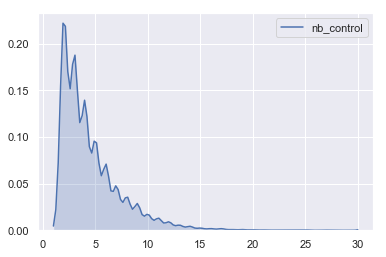

In [49]:
sns.kdeplot(bc_2019_cv_test.nb_control, shade = True, cut=0);

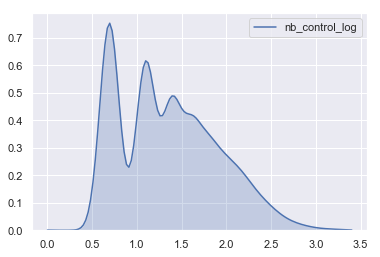

In [107]:
bc_2019_cv_test['nb_control_log'] = np.log(bc_2019_cv_test['nb_control'])
sns.kdeplot(bc_2019_cv_test.nb_control_log, shade = True, cut=0);

In [53]:
bc_2019_cv_4 = bc_2019_cv_test.drop(['Date', 'Num_Train', 'Direction_Ligne', 'Year', 'Month', '15zaine_jour', 'Heure_Origine',  
                        'Ligne_Presence_imposee', 'Montant_operation', 'Type_operation_CC BORD', 'Type_operation_CC CONTROLE',
                        'Type_operation_CC GUICHET', 'Type_operation_PV', 'cv', 'nb_controleurs', 'Heure_Fin', 'Date_1', 
                         'diff_ctrl_1', 'diff_ctrl_2', 'Date_2', 'diff_ctrl_3', 'Date_3', 'nb_control'],
                      axis = 1)
bc_2019_cv_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13617 entries, 1 to 243860
Data columns (total 13 columns):
Sous_Ligne          13617 non-null object
Gare_Origine        13617 non-null object
Gare_Fin            13617 non-null object
jour_semaine        13617 non-null int64
Sens_circulation    13617 non-null int64
h_x                 13617 non-null float64
h_y                 13617 non-null float64
m_x                 13617 non-null float64
m_y                 13617 non-null float64
nb_control_1        13617 non-null int64
nb_control_2        13617 non-null int64
nb_control_3        13617 non-null int64
nb_control_log      13617 non-null float64
dtypes: float64(5), int64(5), object(3)
memory usage: 2.1+ MB


In [54]:
bc_2019_cv_4 = bc_2019_cv_4.join(pd.get_dummies(bc_2019_cv_4.Sous_Ligne, prefix='S_Ligne'))
bc_2019_cv_4 = bc_2019_cv_4.join(pd.get_dummies(bc_2019_cv_4.jour_semaine, prefix='jr_semaine'))
bc_2019_cv_4 = bc_2019_cv_4.join(pd.get_dummies(bc_2019_cv_4.Gare_Origine, prefix='Gare_Origine'))
bc_2019_cv_4 = bc_2019_cv_4.join(pd.get_dummies(bc_2019_cv_4.Gare_Fin, prefix='Gare_Fin'))

bc_2019_cv_4 = bc_2019_cv_4.drop(['Sous_Ligne', 'jour_semaine', 'Gare_Origine', 'Gare_Fin'], axis = 1)

In [59]:
data = bc_2019_cv_4.drop('nb_control_log', axis = 1)
target = bc_2019_cv_4.nb_control_log
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2)

In [58]:
import statsmodels.api as sm

In [70]:
exog, endog = sm.add_constant(X_train), y_train
glm_model = sm.GLM(endog, exog, family = sm.families.Gaussian())
res = glm_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         nb_control_log   No. Observations:                10893
Model:                            GLM   Df Residuals:                    10689
Model Family:                Gaussian   Df Model:                          203
Link Function:               identity   Scale:                         0.39992
Method:                          IRLS   Log-Likelihood:                -10362.
Date:                Sun, 09 May 2021   Deviance:                       4274.7
Time:                        20:22:41   Pearson chi2:                 4.27e+03
No. Iterations:                     3   Covariance Type:             nonrobust
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
const        

In [81]:
pred_train = res.predict(sm.add_constant(X_train))
pred_test = res.predict(sm.add_constant(X_test))
print(mean_squared_error(pred_train, y_train))
print(mean_squared_error(pred_test, y_test))

0.39242996080161163
0.41790860692903314


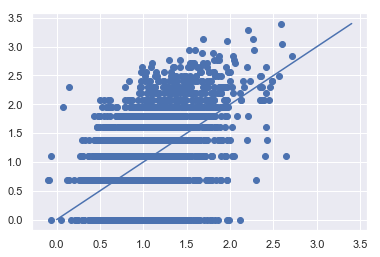

In [83]:
plt.scatter(pred_test, y_test)
plt.plot((y_test.min(),y_test.max()), (y_test.min(),y_test.max()))

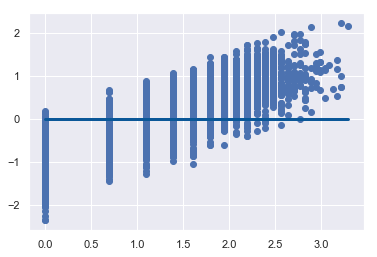

In [82]:
residus = y_train - pred_train
plt.scatter(y_train, residus)
plt.plot((y_train.min(),y_train.max()), (0,0), lw=3, color = '#0a5798');

In [84]:
bc_2019_cv_5 = bc_2019_cv_test.drop(['Date', 'Num_Train', 'Direction_Ligne', 'Year', 'Month', '15zaine_jour', 'Heure_Origine',  
                        'Ligne_Presence_imposee', 'Montant_operation', 'Type_operation_CC BORD', 'Type_operation_CC CONTROLE',
                        'Type_operation_CC GUICHET', 'Type_operation_PV', 'cv', 'nb_controleurs', 'Heure_Fin', 'Date_1', 
                         'diff_ctrl_1', 'diff_ctrl_2', 'Date_2', 'diff_ctrl_3', 'Date_3', 'nb_control',
                                    'Sous_Ligne', 'jour_semaine', 'Gare_Origine', 'Gare_Fin'],
                      axis = 1)
bc_2019_cv_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13617 entries, 1 to 243860
Data columns (total 9 columns):
Sens_circulation    13617 non-null int64
h_x                 13617 non-null float64
h_y                 13617 non-null float64
m_x                 13617 non-null float64
m_y                 13617 non-null float64
nb_control_1        13617 non-null int64
nb_control_2        13617 non-null int64
nb_control_3        13617 non-null int64
nb_control_log      13617 non-null float64
dtypes: float64(5), int64(4)
memory usage: 1.7 MB


In [85]:
data = bc_2019_cv_5.drop('nb_control_log', axis = 1)
target = bc_2019_cv_5.nb_control_log
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2)

In [86]:
exog, endog = sm.add_constant(X_train), y_train
glm_model = sm.GLM(endog, exog, family = sm.families.Gaussian())
res = glm_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         nb_control_log   No. Observations:                10893
Model:                            GLM   Df Residuals:                    10884
Model Family:                Gaussian   Df Model:                            8
Link Function:               identity   Scale:                         0.42798
Method:                          IRLS   Log-Likelihood:                -10830.
Date:                Sun, 09 May 2021   Deviance:                       4658.1
Time:                        20:48:25   Pearson chi2:                 4.66e+03
No. Iterations:                     3   Covariance Type:             nonrobust
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4526      0.015     30.247      0.000       0.423       0.482
Sens_circulation    -0.0186      0

C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [87]:
pred_train = res.predict(sm.add_constant(X_train))
pred_test = res.predict(sm.add_constant(X_test))
print(mean_squared_error(pred_train, y_train))
print(mean_squared_error(pred_test, y_test))

0.4276251645661144
0.42189975623367426


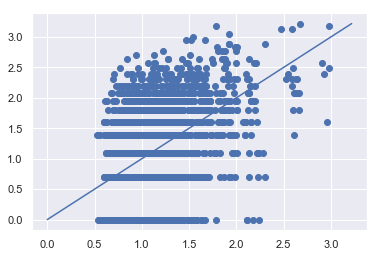

In [89]:
plt.scatter(pred_test, y_test)
plt.plot((y_test.min(),y_test.max()), (y_test.min(),y_test.max()))

In [116]:
bc_2019_cv_6 = bc_2019_cv_test.set_index(bc_2019_cv_test.Sous_Ligne, drop = True)
bc_2019_cv_6 = bc_2019_cv_6.drop(['Sous_Ligne'], axis = 1)

bc_2019_cv_6 = bc_2019_cv_6.drop(['Date', 'Num_Train', 'Direction_Ligne', 'Year', 'Month', '15zaine_jour', 'Heure_Origine',  
                        'Ligne_Presence_imposee', 'Montant_operation', 'Type_operation_CC BORD', 'Type_operation_CC CONTROLE',
                        'Type_operation_CC GUICHET', 'Type_operation_PV', 'cv', 'nb_controleurs', 'Heure_Fin', 'Date_1', 
                         'diff_ctrl_1', 'diff_ctrl_2', 'Date_2', 'diff_ctrl_3', 'Date_3', 'nb_control_log', 'Gare_Origine', 
                                     'Gare_Fin'],
                      axis = 1)
bc_2019_cv_6.head()

,jour_semaine,Sens_circulation,nb_control,h_x,h_y,m_x,m_y,nb_control_1,nb_control_2,nb_control_3
Sous_Ligne,,,,,,,,,,
Metz Ã¢ÂÂ Forbach-SBK,3,1,2,1.0,0.0,5.000000e-01,-0.866025,1,2,1
Metz Ã¢ÂÂ Forbach-SBK,4,1,1,1.0,0.0,5.000000e-01,-0.866025,1,2,1
Metz Ã¢ÂÂ Forbach-SBK,1,1,2,1.0,0.0,6.123234e-17,-1.000000,1,2,1
Metz Ã¢ÂÂ Forbach-SBK,3,1,1,1.0,0.0,6.123234e-17,-1.000000,1,2,1
Metz Ã¢ÂÂ Forbach-SBK,2,0,2,1.0,0.0,1.000000e+00,0.000000,1,4,3


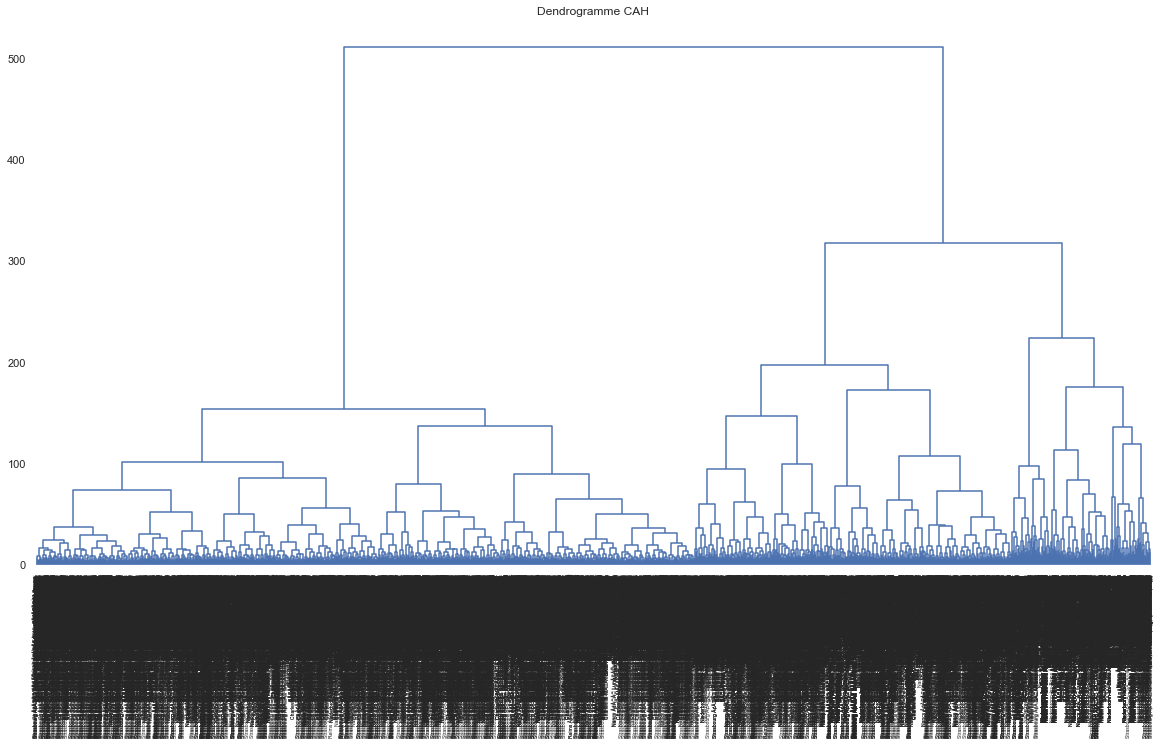

In [109]:
# Importation des packages nécessaires pour la CAH
from scipy.cluster.hierarchy import dendrogram, linkage

# Initialisaion de la figrue
plt.figure(figsize=(20, 10))

# Génération de la matrice des liens
Z = linkage(bc_2019_cv_6, method = 'ward', metric = 'euclidean')

# Affichage du dendrogramme
plt.title("Dendrogramme CAH")
dendrogram(Z, labels = bc_2019_cv_6.index, leaf_rotation = 90., color_threshold = 0)
plt.show()

In [118]:
bc_2019_cv_6 = bc_2019_cv_6.reset_index()
bc_2019_cv_6 = bc_2019_cv_6.drop('Sous_Ligne', axis = 1)
bc_2019_cv_6.head()

,jour_semaine,Sens_circulation,nb_control,h_x,h_y,m_x,m_y,nb_control_1,nb_control_2,nb_control_3
0,3,1,2,1.0,0.0,5.000000e-01,-0.866025,1,2,1
1,4,1,1,1.0,0.0,5.000000e-01,-0.866025,1,2,1
2,1,1,2,1.0,0.0,6.123234e-17,-1.000000,1,2,1
3,3,1,1,1.0,0.0,6.123234e-17,-1.000000,1,2,1
4,2,0,2,1.0,0.0,1.000000e+00,0.000000,1,4,3


In [139]:
from sklearn.cluster import AgglomerativeClustering

clf = AgglomerativeClustering(n_clusters = 3)
clf.fit(bc_2019_cv_6)

labels = pd.DataFrame(clf.labels_)
labels.columns = ['label']

bc_2019_cv_label = pd.concat([bc_2019_cv_6, labels], axis = 1)
bc_2019_cv_label.head()

,jour_semaine,Sens_circulation,nb_control,h_x,h_y,m_x,m_y,nb_control_1,nb_control_2,nb_control_3,label
0,3,1,2,1.0,0.0,5.000000e-01,-0.866025,1,2,1,1
1,4,1,1,1.0,0.0,5.000000e-01,-0.866025,1,2,1,1
2,1,1,2,1.0,0.0,6.123234e-17,-1.000000,1,2,1,1
3,3,1,1,1.0,0.0,6.123234e-17,-1.000000,1,2,1,1
4,2,0,2,1.0,0.0,1.000000e+00,0.000000,1,4,3,1


In [134]:
label_n = bc_2019_cv_label[bc_2019_cv_label['label'] == 0]
data = label_n.drop(['nb_control', 'label'], axis = 1)
target = label_n.nb_control
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2)

# modèle ElasticNetCV
model_en = ElasticNetCV(cv = 8, l1_ratio = (0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), alphas= (0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0))
model_en.fit(X_train, y_train)

print(model_en.score(X_train, y_train))
print(model_en.score(X_test, y_test))

0.0713653234243461
0.08713030467755545


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


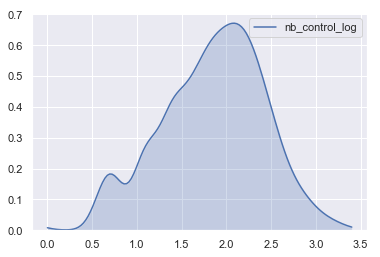

In [145]:
label_0 = bc_2019_cv_label[bc_2019_cv_label['label'] == 0]
label_0['nb_control_log'] = np.log(label_0['nb_control'])
sns.kdeplot(label_0.nb_control_log, shade = True, cut=0);

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


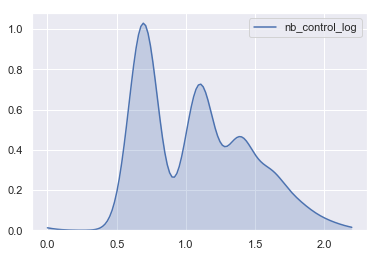

In [146]:
label_1 = bc_2019_cv_label[bc_2019_cv_label['label'] == 1]
label_1['nb_control_log'] = np.log(label_1['nb_control'])
sns.kdeplot(label_1.nb_control_log, shade = True, cut=0);

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


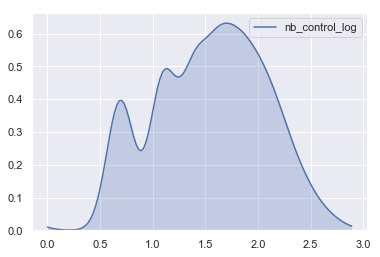

In [147]:
label_2 = bc_2019_cv_label[bc_2019_cv_label['label'] == 2]
label_2['nb_control_log'] = np.log(label_2['nb_control'])
sns.kdeplot(label_2.nb_control_log, shade = True, cut=0);

In [157]:
data = label_0.drop(['nb_control_log', 'nb_control', 'label'], axis = 1)
target = label_0.nb_control_log
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2)

exog, endog = sm.add_constant(X_train), y_train
glm_model = sm.GLM(endog, exog, family = sm.families.Gaussian())
res = glm_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         nb_control_log   No. Observations:                 1364
Model:                            GLM   Df Residuals:                     1354
Model Family:                Gaussian   Df Model:                            9
Link Function:               identity   Scale:                         0.43274
Method:                          IRLS   Log-Likelihood:                -1359.2
Date:                Sun, 09 May 2021   Deviance:                       585.93
Time:                        22:00:53   Pearson chi2:                     586.
No. Iterations:                     3   Covariance Type:             nonrobust
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.2886      0.076     16.870      0.000       1.139       1.438
jour_semaine         0.0442      0

C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [158]:
pred_train = res.predict(sm.add_constant(X_train))
pred_test = res.predict(sm.add_constant(X_test))
print(mean_squared_error(pred_train, y_train))
print(mean_squared_error(pred_test, y_test))

0.4295641481269786
0.4338929783362157


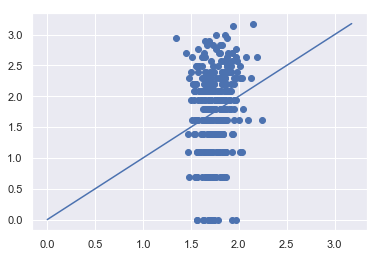

In [159]:
plt.scatter(pred_test, y_test)
plt.plot((y_test.min(),y_test.max()), (y_test.min(),y_test.max()))

In [160]:
data = label_2.drop(['nb_control_log', 'nb_control', 'label'], axis = 1)
target = label_2.nb_control_log
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2)

exog, endog = sm.add_constant(X_train), y_train
glm_model = sm.GLM(endog, exog, family = sm.families.Gaussian())
res = glm_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         nb_control_log   No. Observations:                 3099
Model:                            GLM   Df Residuals:                     3089
Model Family:                Gaussian   Df Model:                            9
Link Function:               identity   Scale:                         0.41881
Method:                          IRLS   Log-Likelihood:                -3043.7
Date:                Sun, 09 May 2021   Deviance:                       1293.7
Time:                        22:01:20   Pearson chi2:                 1.29e+03
No. Iterations:                     3   Covariance Type:             nonrobust
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.6354      0.052     31.512      0.000       1.534       1.737
jour_semaine        -0.0038      0

C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [161]:
pred_train = res.predict(sm.add_constant(X_train))
pred_test = res.predict(sm.add_constant(X_test))
print(mean_squared_error(pred_train, y_train))
print(mean_squared_error(pred_test, y_test))

0.4174555968171498
0.39544010545224517


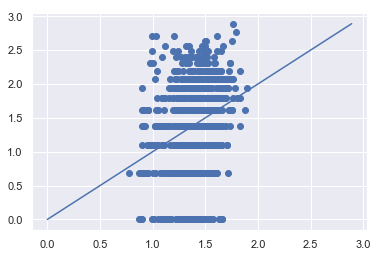

In [162]:
plt.scatter(pred_test, y_test)
plt.plot((y_test.min(),y_test.max()), (y_test.min(),y_test.max()))

In [163]:
bc_2019_cv_label.head()

,jour_semaine,Sens_circulation,nb_control,h_x,h_y,m_x,m_y,nb_control_1,nb_control_2,nb_control_3,label
0,3,1,2,1.0,0.0,5.000000e-01,-0.866025,1,2,1,1
1,4,1,1,1.0,0.0,5.000000e-01,-0.866025,1,2,1,1
2,1,1,2,1.0,0.0,6.123234e-17,-1.000000,1,2,1,1
3,3,1,1,1.0,0.0,6.123234e-17,-1.000000,1,2,1,1
4,2,0,2,1.0,0.0,1.000000e+00,0.000000,1,4,3,1


In [164]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [165]:
data = bc_2019_cv_label.drop(['nb_control', 'label'], axis = 1)
target = bc_2019_cv_label.nb_control
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2)

In [179]:
#poly = PolynomialFeatures(degree = 4)
#X_train_poly = poly.fit_transform(X_train)
polyreg = make_pipeline(PolynomialFeatures(3), LinearRegression())
polyreg.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [180]:
pred_train = polyreg.predict(X_train)
pred_test = polyreg.predict(X_test)
print(mean_squared_error(pred_train, y_train))
print(mean_squared_error(pred_test, y_test))

6.101600649413533
6.2362476741425485


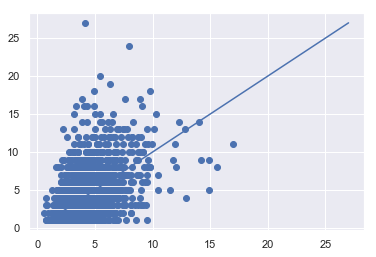

In [181]:
plt.scatter(pred_test, y_test)
plt.plot((y_test.min(),y_test.max()), (y_test.min(),y_test.max()))